In [1]:
# Configure tensorflow and GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
print(f"Number of GPUs available: {len(gpus)}")
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

Number of GPUs available: 1


In [2]:
# Import basic packages
!pip install pandas scikit-learn nltk pathlib
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder

# Packages for model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Set constants
NB_WORDS = 10000 # Number of words in the dictionary
NB_START_EPOCHS = 20 # Number of epochs for training
BATCH_SIZE = 512
MAX_LEN = 20 # Maximum number of sequence in a sentence

In [5]:
# Create some helper functions for the program
def deep_model(model, X_train, X_val, y_train, y_val):
    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        X_train, y_train, 
        epochs=NB_START_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    return history

In [6]:
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history["val_" + metric_name]
    
    e =range(1, NB_START_EPOCHS + 1)
    
    plt.plot(e, metric, "bo", label="Train " + metric_name)
    plt.plot(e, val_metric, "b", label="Validation " + metric_name)
    plt.xlabel("Epoch Number")
    plt.ylabel(metric_name)
    plt.title("Comparing training and validation " + metric_name)
    plt.legend()
    plt.show()

In [7]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(
        X_train, y_train,
        epochs=epoch_stop,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    results = model.evaluate(X_test, y_test)
    print()
    print("Test accuracy: {0:.2f}%".format(results[1]*100))
    return results

In [8]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words("english")
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1]
    return " ".join(clean_words)

In [9]:
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

In [10]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [11]:
def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history["val_loss"]) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

## Data Preparation

In [12]:
df = pd.read_csv("data/Tweets.csv")
df = df.reindex(np.random.permutation(df.index))
df = df[["text", "airline_sentiment"]]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
226,hold times call center bit much,negative
3296,delayed flight SLC 2.5 hours. What gives? #sn...,negative
5147,Am flying Spirit air?,negative
9873,"flight 2031, worst experience we've ever flig...",negative
9726,always nice customer service manager threate...,negative


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=1337)

In [14]:
tk = Tokenizer(
    num_words=NB_WORDS,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
    lower=True,
    char_level=False,
    split=" "
)
tk.fit_on_texts(X_train)

In [15]:
X_train_oh = tk.texts_to_matrix(X_train, mode="binary")
X_test_oh = tk.texts_to_matrix(X_test, mode="binary")

In [16]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [17]:
X_train_rest, X_val, y_train_rest, y_val = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=1337)

In [18]:
# Create a baseline model
base_model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(NB_WORDS,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
], name="baseline")

Epoch 1/20
24/24 [==============================] - 2s 29ms/step - loss: 0.9630 - accuracy: 0.5632 - val_loss: 0.7111 - val_accuracy: 0.6760
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.6226 - accuracy: 0.7390 - val_loss: 0.5550 - val_accuracy: 0.7777
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.4281 - accuracy: 0.8514 - val_loss: 0.5116 - val_accuracy: 0.7959
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.3307 - accuracy: 0.8867 - val_loss: 0.5196 - val_accuracy: 0.7891
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.2624 - accuracy: 0.9118 - val_loss: 0.5307 - val_accuracy: 0.8012
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.2200 - accuracy: 0.9236 - val_loss: 0.5685 - val_accuracy: 0.7898
Epoch 7/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1831 - accuracy: 0.9382 - val_loss: 0.6070 - val_accuracy: 0.7807
Epoch 8/20
24/24 

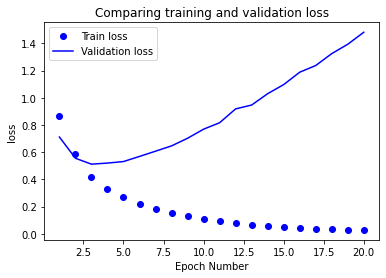

In [19]:
base_history = deep_model(base_model, X_train_rest, X_val, y_train_rest, y_val)
base_min = optimal_epoch(base_history)

eval_metric(base_model, base_history, 'loss')

In [20]:
reduced_model = models.Sequential([
    layers.Dense(16, activation="relu", input_shape=(NB_WORDS,)),
    layers.Dense(3, activation="softmax")
], name="reduced")

Epoch 1/20
24/24 [==============================] - 1s 20ms/step - loss: 1.0347 - accuracy: 0.5705 - val_loss: 0.8981 - val_accuracy: 0.6457
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 0.8488 - accuracy: 0.6650 - val_loss: 0.7819 - val_accuracy: 0.6745
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.7210 - accuracy: 0.7089 - val_loss: 0.7059 - val_accuracy: 0.7094
Epoch 4/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6391 - accuracy: 0.7456 - val_loss: 0.6528 - val_accuracy: 0.7382
Epoch 5/20
24/24 [==============================] - 0s 9ms/step - loss: 0.5620 - accuracy: 0.7842 - val_loss: 0.6122 - val_accuracy: 0.7716
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.5199 - accuracy: 0.8199 - val_loss: 0.5813 - val_accuracy: 0.7807
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4709 - accuracy: 0.8418 - val_loss: 0.5582 - val_accuracy: 0.7838
Epoch 8/20
24/2

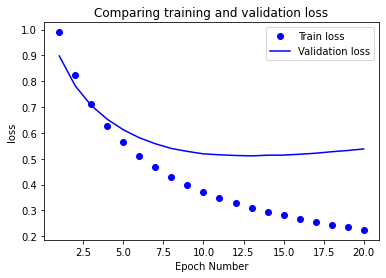

In [21]:
reduced_history = deep_model(reduced_model, X_train_rest, X_val, y_train_rest, y_val)
reduced_min = optimal_epoch(reduced_history)

eval_metric(reduced_model, reduced_history, 'loss')

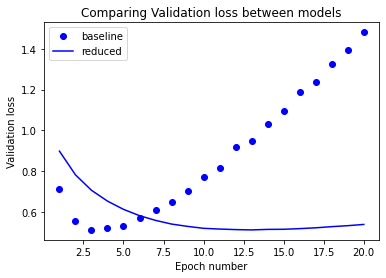

In [22]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

In [23]:
reg_model = models.Sequential([
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=(NB_WORDS,)),
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation="relu"),
    layers.Dense(3, activation="softmax")
], name="l2_reg")

Epoch 1/20
24/24 [==============================] - 1s 16ms/step - loss: 1.0480 - accuracy: 0.5793 - val_loss: 0.7614 - val_accuracy: 0.7155
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6830 - accuracy: 0.7577 - val_loss: 0.6468 - val_accuracy: 0.7663
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.5336 - accuracy: 0.8444 - val_loss: 0.6108 - val_accuracy: 0.7959
Epoch 4/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4655 - accuracy: 0.8759 - val_loss: 0.6117 - val_accuracy: 0.8035
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4205 - accuracy: 0.8898 - val_loss: 0.6299 - val_accuracy: 0.7830
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.3904 - accuracy: 0.9008 - val_loss: 0.6381 - val_accuracy: 0.7974
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.3697 - accuracy: 0.9132 - val_loss: 0.6415 - val_accuracy: 0.7936
Epoch 8/20
24

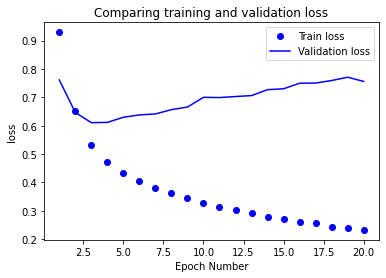

In [24]:
reg_history = deep_model(reg_model, X_train_rest, X_val, y_train_rest, y_val)
reg_min = optimal_epoch(reg_history)

eval_metric(reg_model, reg_history, 'loss')

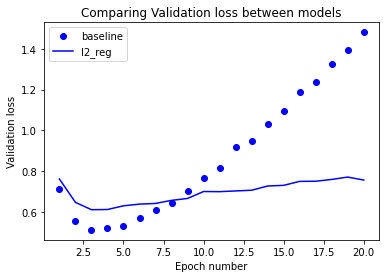

In [25]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

In [26]:
drop_model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(NB_WORDS,)),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
], name="dropout")

In [27]:
drop_history = deep_model(drop_model, X_train_rest, X_val, y_train_rest, y_val)
drop_min = optimal_epoch(drop_history)

Epoch 1/20
24/24 [==============================] - 1s 15ms/step - loss: 0.9648 - accuracy: 0.5884 - val_loss: 0.7593 - val_accuracy: 0.6161
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7390 - accuracy: 0.6417 - val_loss: 0.6614 - val_accuracy: 0.7238
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6255 - accuracy: 0.7404 - val_loss: 0.5897 - val_accuracy: 0.7815
Epoch 4/20
24/24 [==============================] - 0s 10ms/step - loss: 0.5388 - accuracy: 0.8087 - val_loss: 0.5597 - val_accuracy: 0.7800
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4733 - accuracy: 0.8330 - val_loss: 0.5263 - val_accuracy: 0.7891
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.4139 - accuracy: 0.8538 - val_loss: 0.5189 - val_accuracy: 0.7936
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.3753 - accuracy: 0.8687 - val_loss: 0.5191 - val_accuracy: 0.7921
Epoch 8/20
24

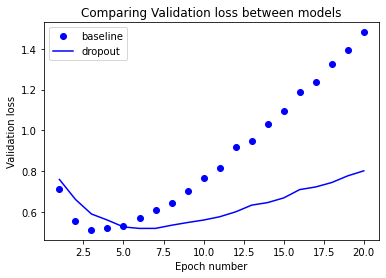

In [28]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [29]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

Epoch 1/3
26/26 [==============================] - 0s 8ms/step - loss: 0.1583 - accuracy: 0.9670
Epoch 2/3
26/26 [==============================] - 0s 8ms/step - loss: 0.1005 - accuracy: 0.9735
Epoch 3/3
46/46 [==============================] - 0s 2ms/step - loss: 1.2823 - accuracy: 0.7514

Test accuracy: 75.14%
Epoch 1/13
26/26 [==============================] - 0s 7ms/step - loss: 0.2484 - accuracy: 0.9142
Epoch 2/13
26/26 [==============================] - 0s 7ms/step - loss: 0.2375 - accuracy: 0.9167
Epoch 3/13
26/26 [==============================] - 0s 7ms/step - loss: 0.2275 - accuracy: 0.9210
Epoch 4/13
26/26 [==============================] - 0s 8ms/step - loss: 0.2185 - accuracy: 0.9248
Epoch 5/13
26/26 [==============================] - 0s 8ms/step - loss: 0.2099 - accuracy: 0.9273
Epoch 6/13
26/26 [==============================] - 0s 8ms/step - loss: 0.2018 - accuracy: 0.9306
Epoch 7/13
26/26 [==============================] - 0s 8ms/step - loss: 0.1944 - accuracy: 0.9331
